In [1]:
# Cell 1
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import json

# Import các module vừa tạo
from preprocessing import load_datasets
from eda import show_random_bright_images_train
from Resnet50_LeTriThien import build_model
from evaluation import plot_history, evaluate_model, run_demo 


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Cấu hình đường dẫn TRAIN_DIR: c:\Users\ASUS\Documents\Nhom6_ML\data\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train


In [2]:
# Cell 2
from preprocessing import load_datasets, clean_data
from eda import show_random_bright_images_train  # Đảm bảo import đúng

clean_data()
train_ds, valid_ds, test_ds, class_names = load_datasets()

NUM_CLASSES = len(class_names)
print(f"Số lớp: {NUM_CLASSES}")

# Kiểm tra lớp có ảnh sáng trước khi hiển thị
try:
    show_random_bright_images_train("Apple___healthy", max_show=5)
except Exception as e:
    print(f"Không thể hiển thị ảnh sáng: {e}")

Đang chạy quá trình lọc và sửa ảnh...
Tổng ảnh dùng để train: 68376 (trong c:\Users\ASUS\Documents\Nhom6_ML\data\train_clean1)

Đang nạp dữ liệu...
Found 68376 files belonging to 38 classes.
Using 54701 files for training.
Found 68376 files belonging to 38 classes.
Using 13675 files for validation.
Đã tìm thấy 38 lớp bệnh.
Thư mục Test có 33 ảnh, sẽ dùng cho demo trực quan.
Số lớp: 38

Đang quét lớp 'Apple___healthy' (Tổng: 0 ảnh)...
Không tìm thấy ảnh nào quá sáng trong lớp Apple___healthy.


In [3]:
# Cell 3
# 3. Dựng Model
model = build_model(NUM_CLASSES)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()



Khởi tạo Model ResNet50 cho 38 phân lớp...
   - Chế độ: Transfer Learning (Đóng băng Base Model)


Model: "ResNet50_TransferLearning"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 224, 224)  │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 224, 224)  │          0 │ data_augmentatio… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 224, 224,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ add[0][0]         │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pooling  │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ global_avg_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_256 (Dense)   │ (None, 256)       │    524,544 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_256[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 38)        │      9,766 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,122,022 (92.02 MB)

 Trainable params: 534,310 (2.04 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [4]:
# Cell 4

checkpoint = ModelCheckpoint("best_resnet50.keras", save_best_only=True, monitor="val_loss", mode="min", verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6, verbose=1)

history = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10, # Cấu hình EPOCHS
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# Lưu class names
with open("class_names.json", "w", encoding="utf-8") as f:
    json.dump(class_names, f, ensure_ascii=False)


Epoch 1/10
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.4101 - loss: 2.2071
Epoch 1: val_loss improved from None to 0.32763, saving model to best_resnet50.keras

Epoch 1: finished saving model to best_resnet50.keras
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 1462s 830ms/step - accuracy: 0.6105 - loss: 1.3747 - val_accuracy: 0.9027 - val_loss: 0.3276 - learning_rate: 1.0000e-04
Epoch 2/10
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.8307 - loss: 0.5492
Epoch 2: val_loss improved from 0.32763 to 0.23223, saving model to best_resnet50.keras

Epoch 2: finished saving model to best_resnet50.keras
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 1422s 825ms/step - accuracy: 0.8453 - loss: 0.4985 - val_accuracy: 0.9246 - val_loss: 0.2322 - learning_rate: 1.0000e-04
Epoch 3/10
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.8756 - loss: 0.3920
Epoch 3: val_loss improved from 0.23223 to 0.20048, saving model to best_resnet50.keras

Epoch 3: finished saving model to best_resnet50.keras


--- BIỂU ĐỒ ---


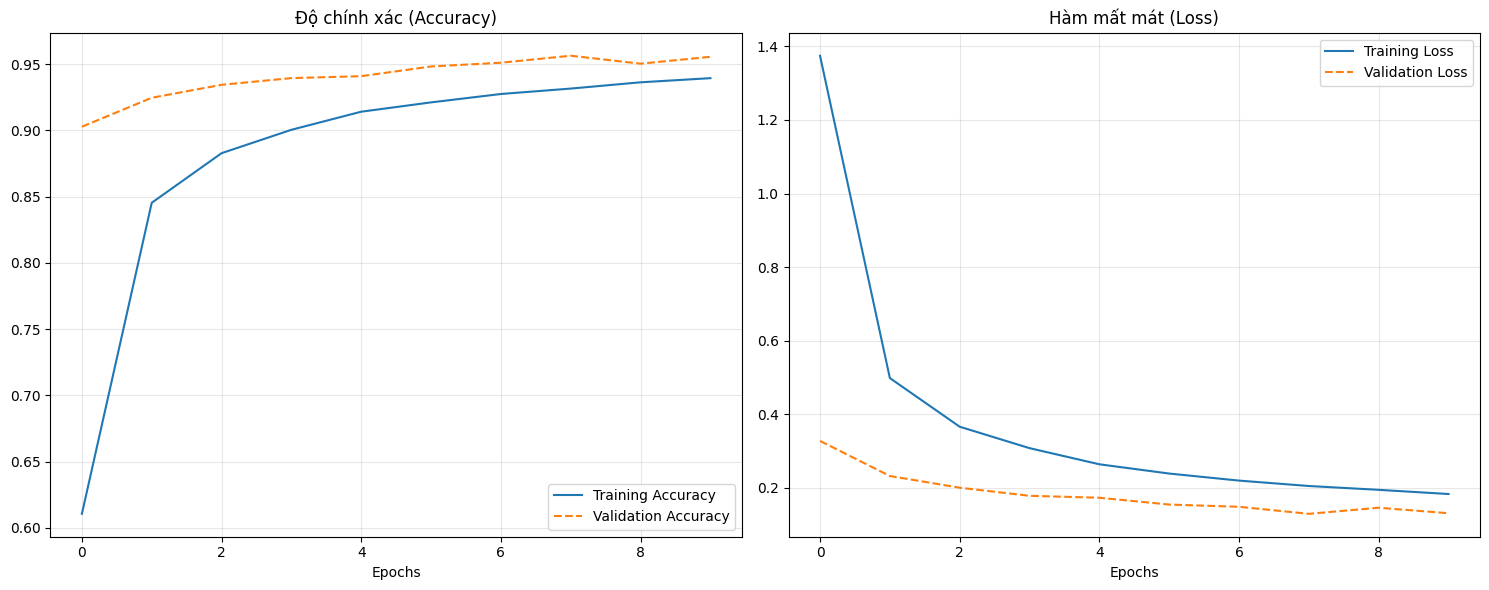


--- DEMO ---
Không tìm thấy folder: ..\data\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\test


In [5]:
# Cell 5
# 5. Đánh giá & Demo (Quan trọng nhất để show kết quả)
print("--- BIỂU ĐỒ ---")
plot_history(history)


print("\n--- DEMO ---")
run_demo(model, class_names)

 Đang load lại Model cũ (trước khi Fine-tuning) để kiểm tra...
KẾT QUẢ TRƯỚC KHI FINE-TUNING 


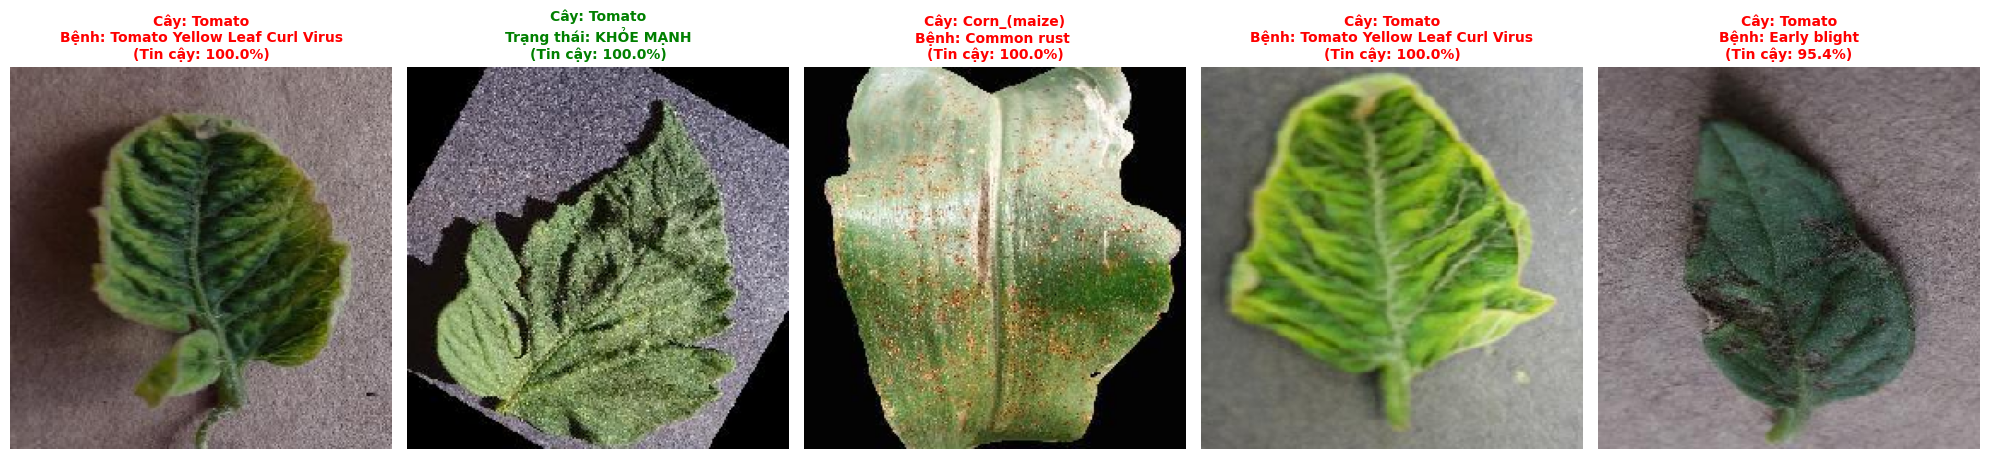

In [8]:
import os
import tensorflow as tf

# Đường dẫn ảnh test
my_test_path = os.path.join("..", "data", "test", "test")

print(" Đang load lại Model cũ (trước khi Fine-tuning) để kiểm tra...")
# Load lại file best_resnet50.keras (Model lúc chưa Fine-tune)
model_before = tf.keras.models.load_model("best_resnet50.keras")

if os.path.exists(my_test_path):
    print("KẾT QUẢ TRƯỚC KHI FINE-TUNING ")
    run_demo(model_before, class_names, demo_folder_path=my_test_path)
else:
    print(" Không tìm thấy folder ảnh test.")

Bật chế độ Fine-tuning (mở khóa 50 layer cuối)...
Epoch 1/5
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9047 - loss: 0.3087
Epoch 1: val_loss improved from 0.12948 to 0.09926, saving model to best_resnet50.keras

Epoch 1: finished saving model to best_resnet50.keras
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 2139s 1s/step - accuracy: 0.9342 - loss: 0.2056 - val_accuracy: 0.9660 - val_loss: 0.0993 - learning_rate: 1.0000e-05
Epoch 2/5
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9639 - loss: 0.1071
Epoch 2: val_loss improved from 0.09926 to 0.06837, saving model to best_resnet50.keras

Epoch 2: finished saving model to best_resnet50.keras
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 2164s 1s/step - accuracy: 0.9668 - loss: 0.0989 - val_accuracy: 0.9764 - val_loss: 0.0684 - learning_rate: 1.0000e-05
Epoch 3/5
1710/1710 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9759 - loss: 0.0726
Epoch 3: val_loss improved from 0.06837 to 0.04602, saving model to best_resnet50.keras

Epoch 3: finished s

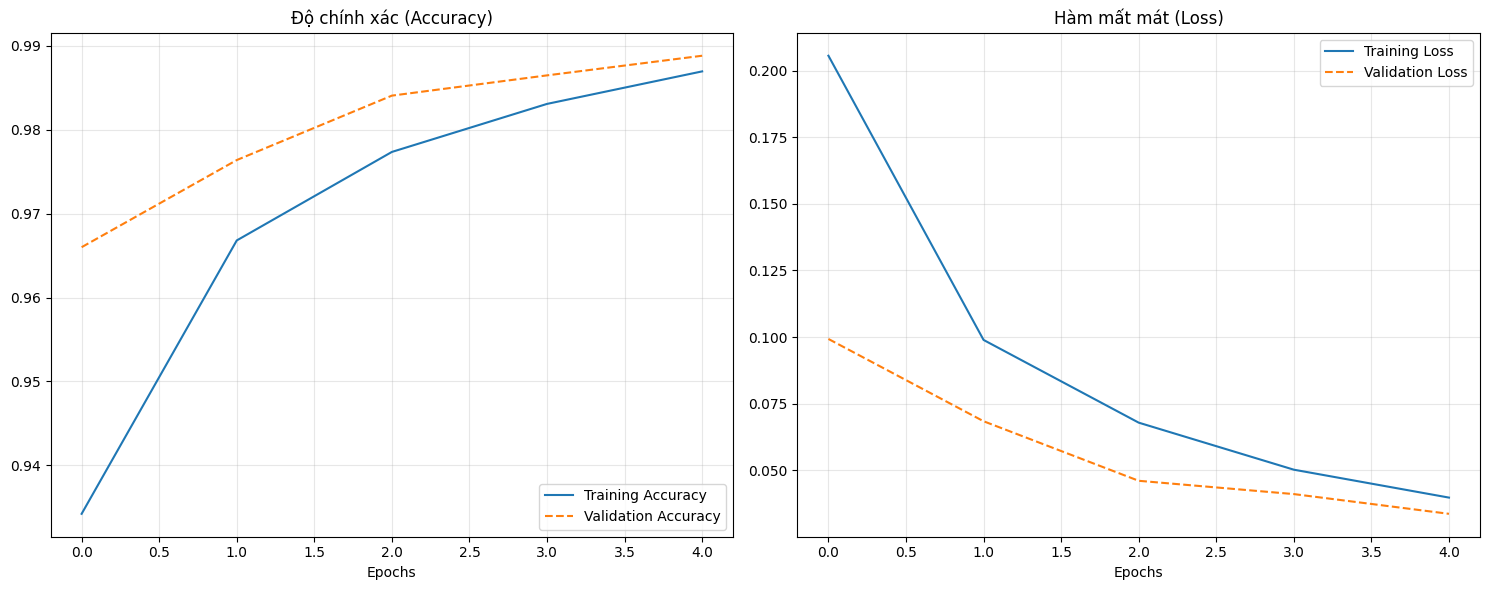


--- ĐÁNH GIÁ SAU FINE-TUNING ---
Đang dự đoán trên tập Test...


TypeError: 'NoneType' object is not iterable

In [6]:
# Cell 6 
print("Bật chế độ Fine-tuning (mở khóa 50 layer cuối)...")


resnet_layer = model.get_layer("resnet50")
resnet_layer.trainable = True

# Đóng băng tất cả trừ 50 layer cuối
for layer in resnet_layer.layers[:-50]:
    layer.trainable = False

# Compile lại với learning rate nhỏ hơn
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Huấn luyện thêm vài epoch để tinh chỉnh
history_finetune = model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=5,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

# Đánh giá lại sau fine-tuning
print("\n--- BIỂU ĐỒ SAU FINE-TUNING ---")
plot_history(history_finetune)

print("\n--- ĐÁNH GIÁ SAU FINE-TUNING ---")
evaluate_model(model, test_ds, class_names)

print("\n--- DEMO SAU FINE-TUNING ---")
run_demo(model, class_names)


Đang chuyển hướng sang lấy dữ liệu từ: ..\data\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\valid
Found 17572 files belonging to 38 classes.
 Đã nạp dữ liệu thành công! Đang tiến hành chấm điểm

 BẢNG ĐIỂM CHI TIẾT SAU FINE-TUNING
Đang dự đoán trên tập Test...

Classification Report
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.99      0.98       504
                                 Apple___Black_rot       0.99      1.00      1.00       497
                          Apple___Cedar_apple_rust       1.00      0.94      0.97       440
                                   Apple___healthy       0.99      1.00      1.00       502
                               Blueberry___healthy       0.96      1.00      0.98       454
          Cherry_(including_sour)___Powdery_mildew       1.00      0.99      1.00       421
                 Cherry_(including_sour)

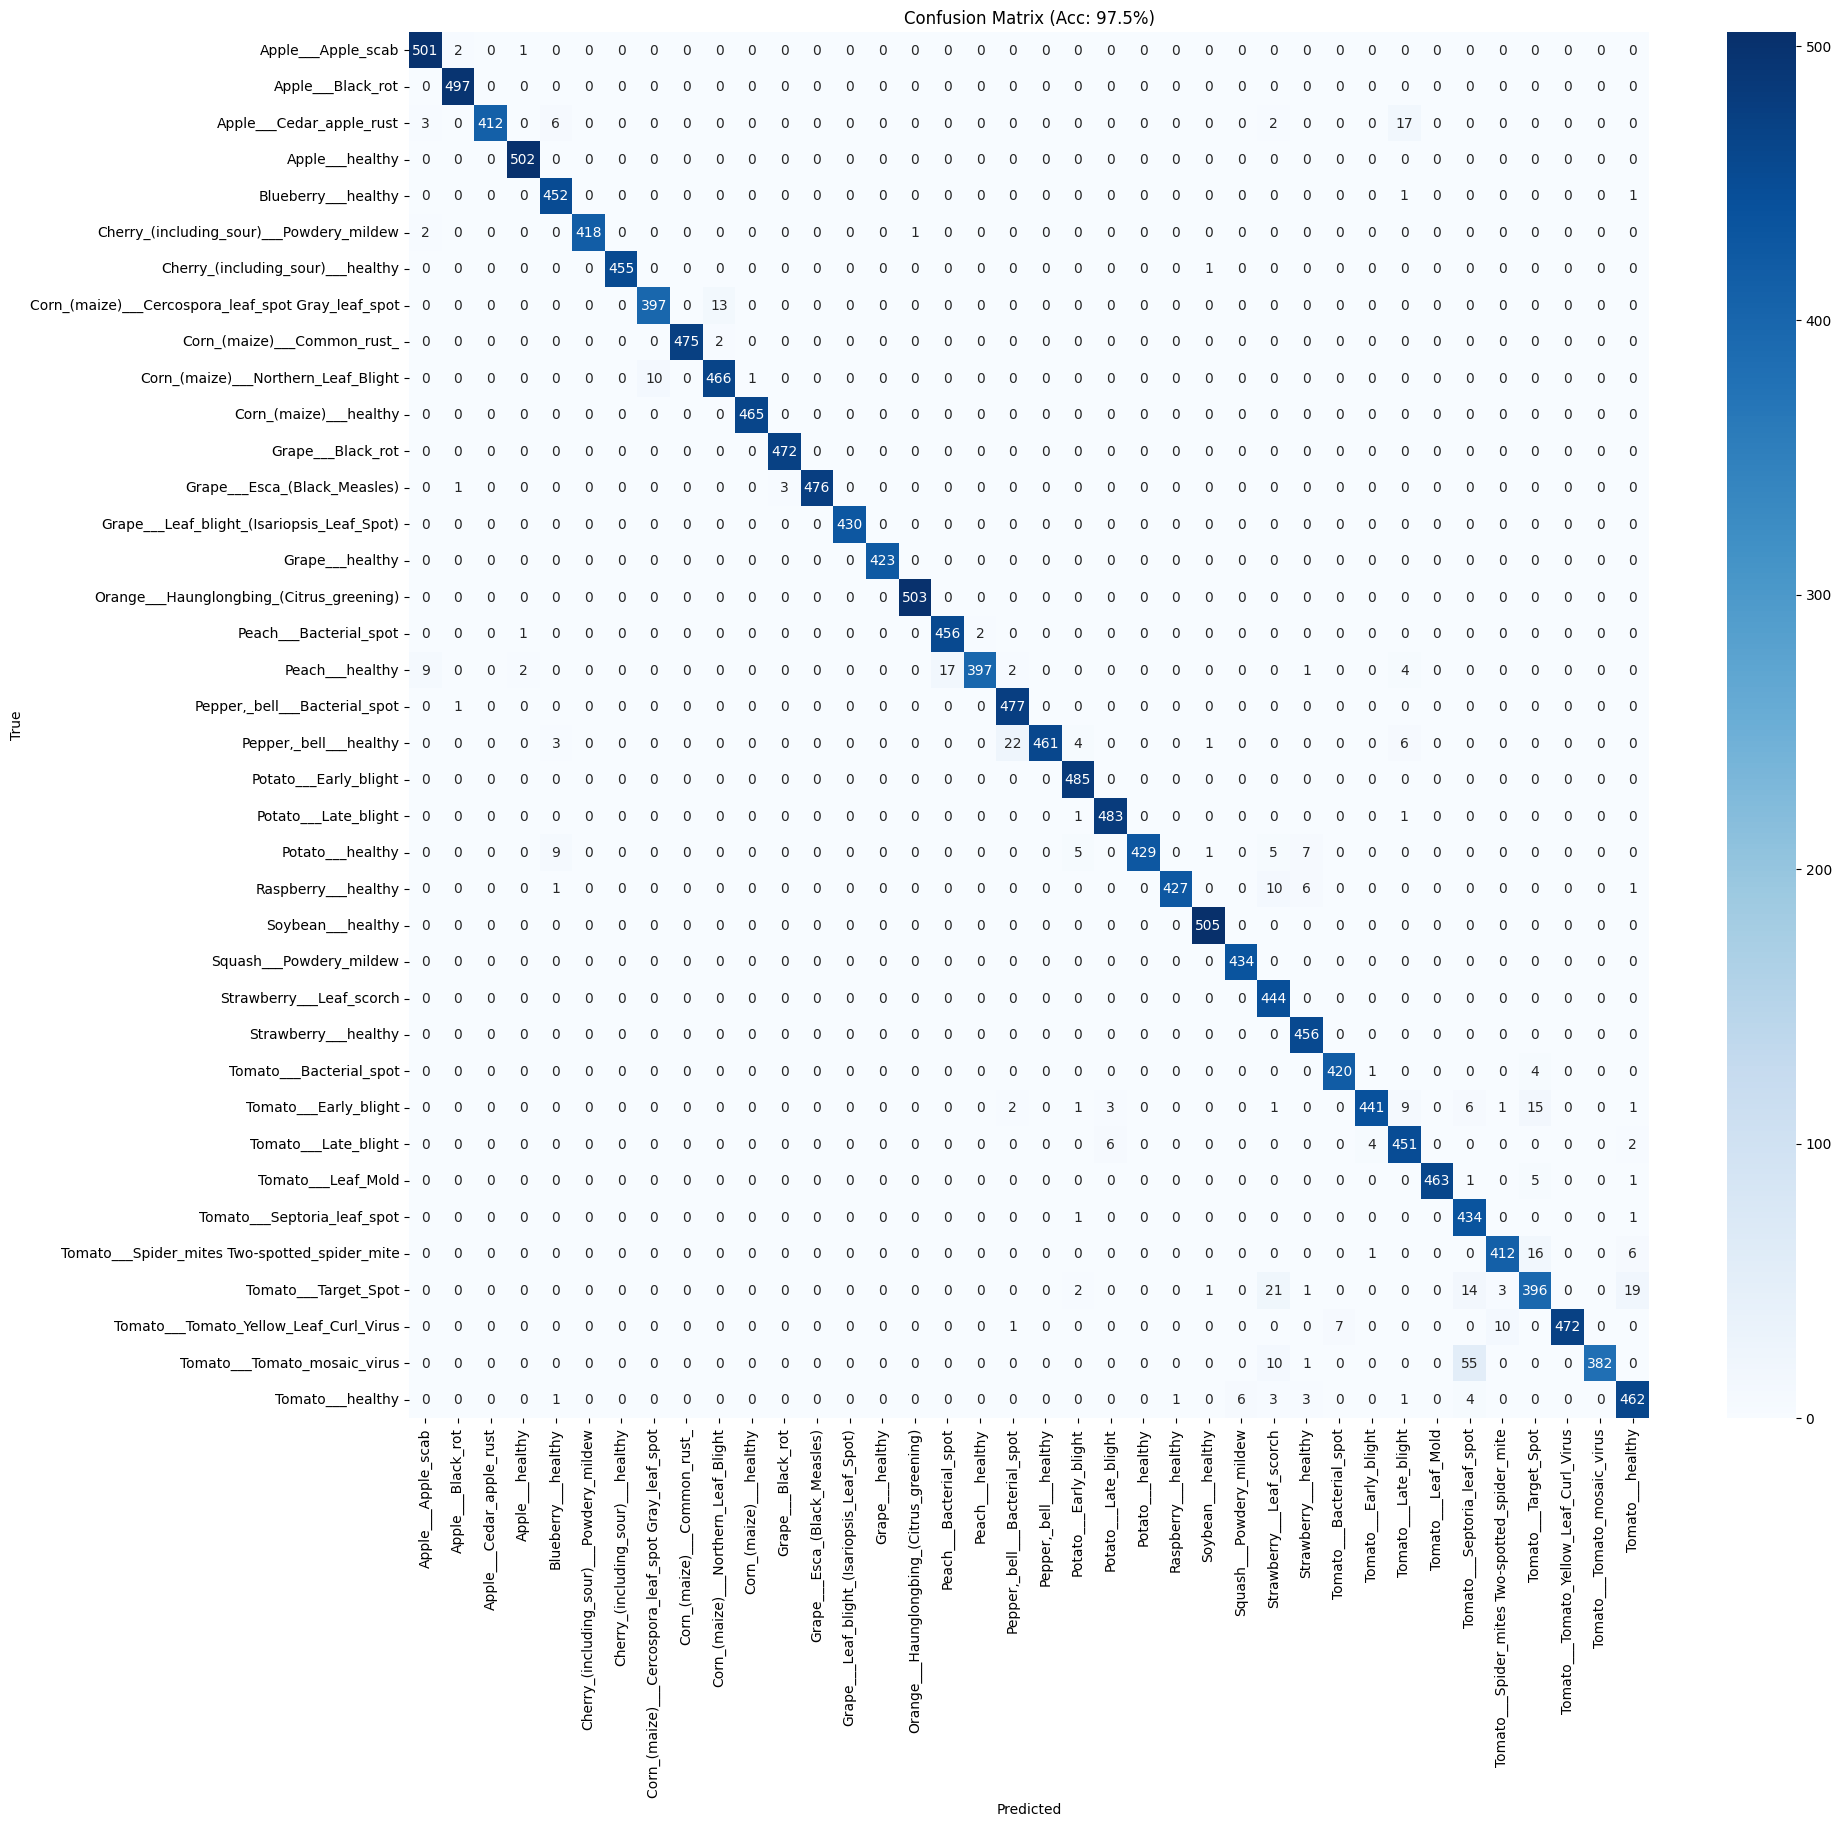

In [11]:
import os
import tensorflow as tf


valid_path = os.path.join("..", "data", "New Plant Diseases Dataset(Augmented)", 
                          "New Plant Diseases Dataset(Augmented)", "valid")

print(f"Đang chuyển hướng sang lấy dữ liệu từ: {valid_path}")

if os.path.exists(valid_path):
    # 2. Tạo test_ds từ tập Valid
    test_ds = tf.keras.utils.image_dataset_from_directory(
        valid_path,
        seed=123,
        image_size=(224, 224),
        batch_size=32,
        shuffle=False # Quan trọng: Không xáo trộn để khớp với nhãn
    )
    
    print(" Đã nạp dữ liệu thành công! Đang tiến hành chấm điểm")
    
    # 3. Chạy đánh giá để ra bảng điểm chi tiết
    print("\n BẢNG ĐIỂM CHI TIẾT SAU FINE-TUNING")
    evaluate_model(model, test_ds, class_names)
    
else:
    print(f" Không tìm thấy thư mục Valid tại: {valid_path}")
    print("Bạn hãy kiểm tra lại đường dẫn folder valid trong máy nhé.")

 KẾT QUẢ SAU KHI FINE-TUNING (Model hiện tại)


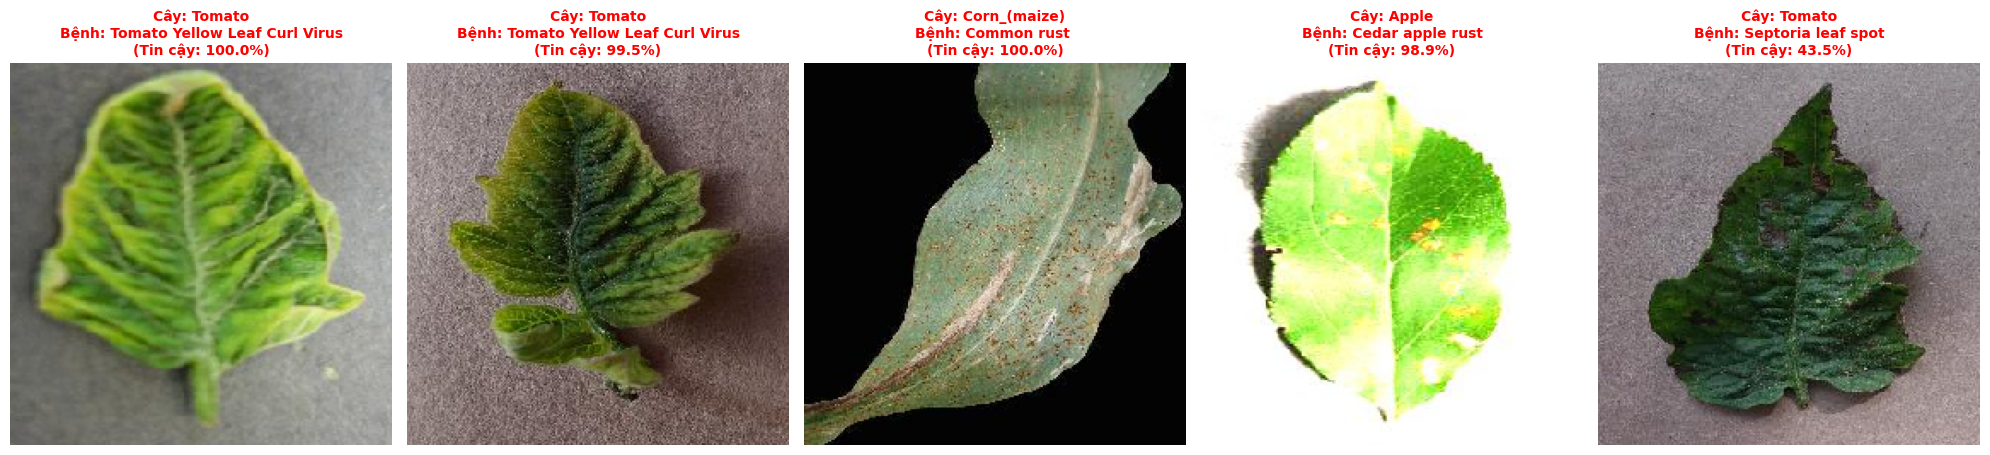

In [12]:
import os

# Đường dẫn ảnh test
my_test_path = os.path.join("..", "data", "test", "test")

if os.path.exists(my_test_path):
    print(" KẾT QUẢ SAU KHI FINE-TUNING (Model hiện tại)")
    # Dùng biến 'model' đang có sẵn trong RAM (đã được Fine-tune ở Cell 6)
    run_demo(model, class_names, demo_folder_path=my_test_path)
else:
    print("Không tìm thấy folder ảnh test.")